Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-04-14 05:38:16.495112: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 05:38:16.495236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 05:38:16.753041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
# data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
# data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

data_dir_train = pathlib.Path("/kaggle/input/melenoma-data/dataset/Train")
data_dir_test = pathlib.Path('/kaggle/input/melenoma-data/dataset/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height, img_width), seed=42, validation_split=0.3, subset='training', label_mode='categorical')
train_ds

Found 2239 files belonging to 9 classes.
Using 1568 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height, img_width), seed=123, validation_split=0.2, subset='validation', label_mode='categorical')
val_ds

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

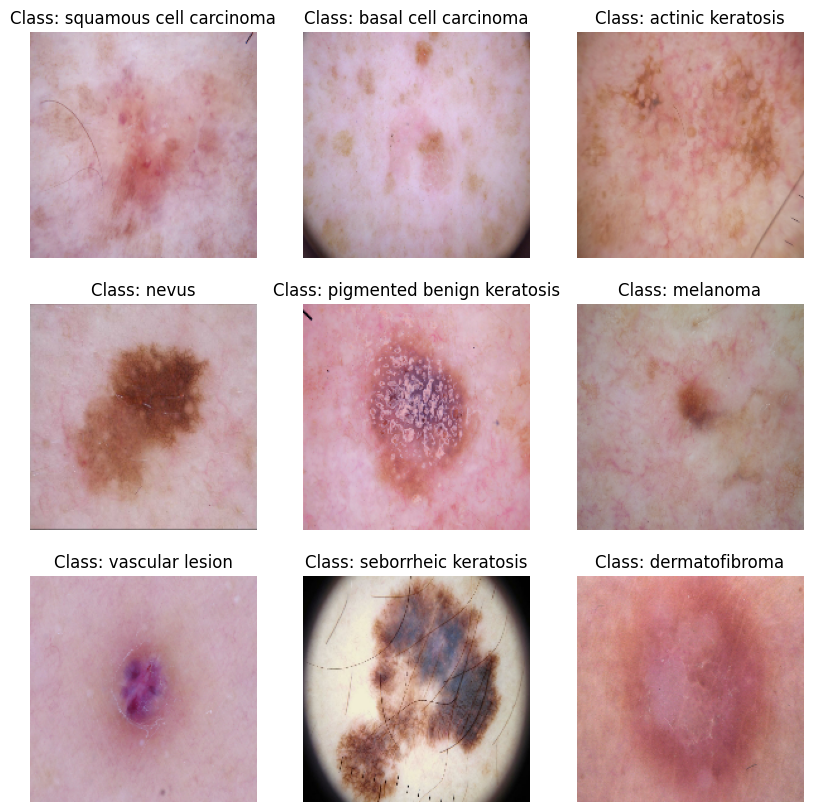

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
class_names = train_ds.class_names

one_hot_encoded_classnames = { class_name: idx for idx,class_name in enumerate(class_names) }
is_label_accounted_flag = [ False for i in range(len(class_names)) ]

fig = plt.figure(figsize=(10,10))
plot_count = 1

for image_batch,one_hot_label_batch in train_ds:
  for image,one_hot_label in zip(image_batch,one_hot_label_batch):
    label = list(one_hot_label.numpy()).index(1)

    if is_label_accounted_flag[label]:
      continue
    
    ax = plt.subplot(3, 3, plot_count)
    ax.imshow(image.numpy().astype(np.uint8))
    ax.axis('off')
    ax.set_title(f"Class: {class_names[label]}")
    
    plot_count += 1
    is_label_accounted_flag[label] = True

    if all(is_label_accounted_flag):
      break

    print()

  if all(is_label_accounted_flag):
      break
        
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
no_of_classes = len(class_names)

model = Sequential((
    layers.Input((180,180,3)),
    
    layers.Rescaling(scale=1./255.),

    layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    layers.MaxPool2D(pool_size=(2,2)),

    layers.Flatten(),
    
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dense(20, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(no_of_classes, activation='softmax')
))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 180, 180, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 180, 180, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 81000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     8,100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           189 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,104,059 (30.91 MB)

 Trainable params: 8,103,779 (30.91 MB)

 Non-trainable params: 280 (1.09 KB)

### Train the model

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Num GPUs Available:  2
Epoch 1/40
 7/49 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1077 - loss: 2.4741 

I0000 00:00:1713073140.431894      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713073140.451174      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1997 - loss: 2.2210

W0000 00:00:1713073143.756783      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 106ms/step - accuracy: 0.2012 - loss: 2.2177 - val_accuracy: 0.1544 - val_loss: 2.1757
Epoch 2/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4701 - loss: 1.6090 - val_accuracy: 0.2058 - val_loss: 2.1420
Epoch 3/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5522 - loss: 1.3414 - val_accuracy: 0.2506 - val_loss: 2.1411
Epoch 4/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6844 - loss: 1.0705 - val_accuracy: 0.2304 - val_loss: 2.2032
Epoch 5/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7813 - loss: 0.8108 - val_accuracy: 0.2506 - val_loss: 2.2490
Epoch 6/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8870 - loss: 0.5289 - val_accuracy: 0.2640 - val_loss: 2.1859
Epoch 7/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9529 - loss: 0.3401 - val_accuracy: 0.2595 - val_loss: 2.3475
Epoch 8/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9490 - loss: 0.2541 - val_accuracy: 0.3915 - val_loss: 

### Visualizing training results

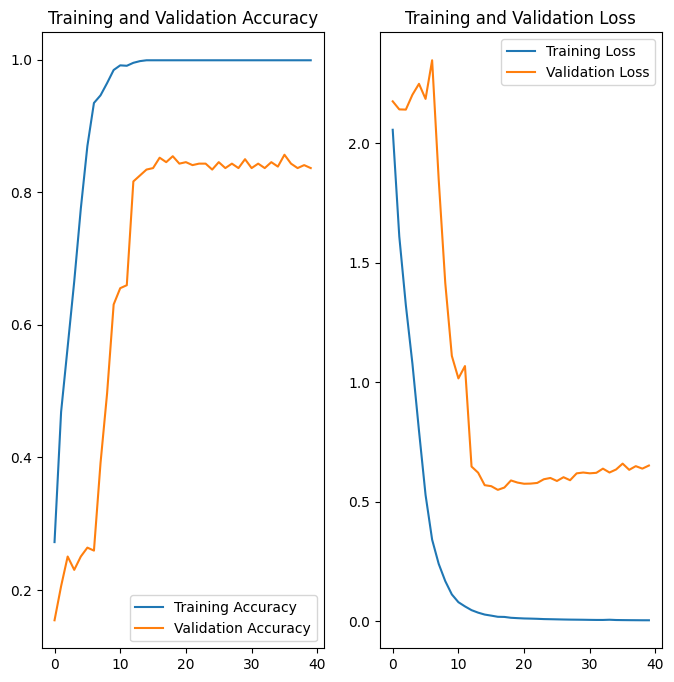

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

data_augmentation = Sequential((
    layers.RandomFlip(seed=42),
    layers.RandomFlip(seed=144),
#     layers.RandomTranslation(0.025, 0.025, seed=42),
#     layers.RandomZoom((0,-0.025), seed=42),
#     layers.RandomContrast(0.025, seed=42),
#     layers.RandomBrightness(0.025, seed=42),
))

Original Image


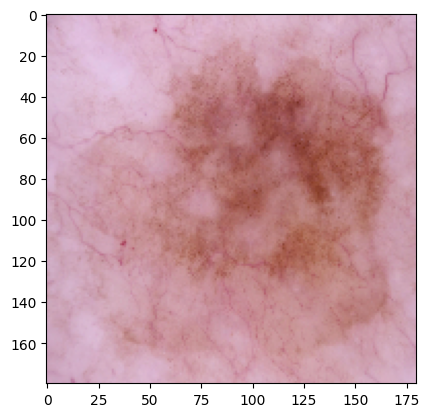


Augmented Images


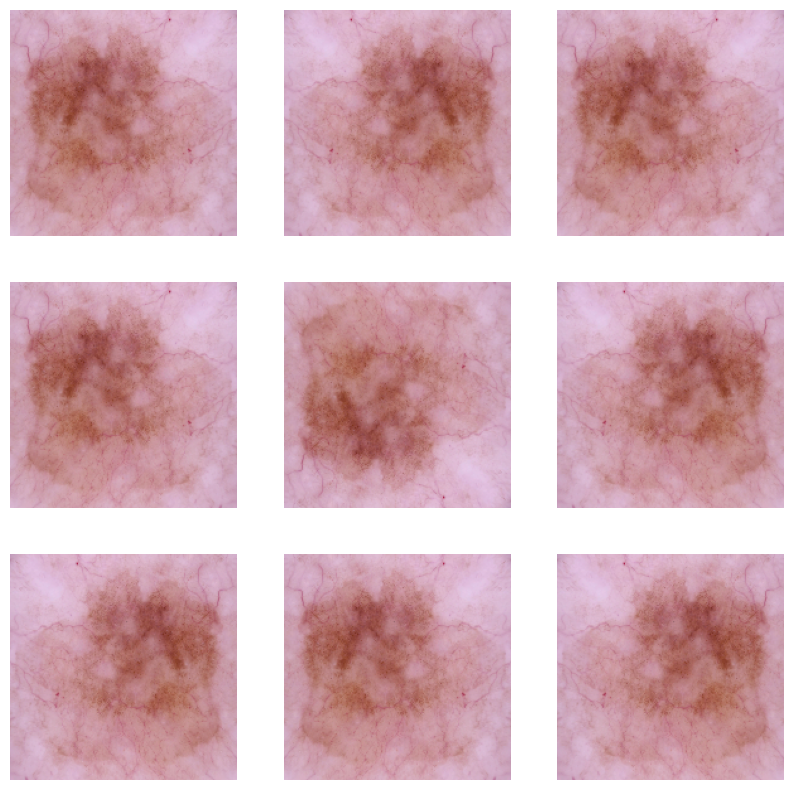

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

for image_batch, _ in train_ds:
    org_image = image_batch[0]
    print("Original Image")
    plt.imshow(org_image.numpy().astype("int"))
    plt.show()
    
    print("\nAugmented Images")
    fig, ax = plt.subplots(3, 3, figsize=(10,10))
    for i in range(3):
        for j in range(3):
            aug_image_batch = data_augmentation(image_batch)
            a_aug_image = aug_image_batch[0]
            a_aug_image = a_aug_image.numpy().astype("int")
            
            
            
            ax[i,j].imshow(a_aug_image)
            ax[i,j].axis('off')
            
    plt.show()
    break

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

no_of_classes = len(class_names)

model = Sequential((
    layers.Input((180,180,3)),
    data_augmentation,
    layers.Rescaling(scale=1./255.),

    layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    layers.MaxPool2D(pool_size=(2,2)),

    layers.Flatten(),
    
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dense(20, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(no_of_classes, activation='softmax')
))

### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 180, 180, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 180, 180, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 180, 180, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 90, 90, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 81000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     8,100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           189 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,104,059 (30.91 MB)

 Trainable params: 8,103,779 (30.91 MB)

 Non-trainable params: 280 (1.09 KB)

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Num GPUs Available:  2
Epoch 1/100
 5/49 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1647 - loss: 2.5285

W0000 00:00:1713073204.152102      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2413 - loss: 2.2432

W0000 00:00:1713073205.868683      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.2426 - loss: 2.2387 - val_accuracy: 0.1387 - val_loss: 2.4246
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4608 - loss: 1.5911 - val_accuracy: 0.1521 - val_loss: 2.3561
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5243 - loss: 1.4077 - val_accuracy: 0.1655 - val_loss: 2.2818
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5389 - loss: 1.3260 - val_accuracy: 0.2438 - val_loss: 2.2349
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5678 - loss: 1.2202 - val_accuracy: 0.2148 - val_loss: 2.2737
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6155 - loss: 1.1143 - val_accuracy: 0.2416 - val_loss: 2.1429
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6899 - loss: 0.9580 - val_accuracy: 0.2864 - val_loss: 1.9707
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6949 - loss: 0.9241 - val_accuracy: 0.3333 - val_

### Visualizing the results

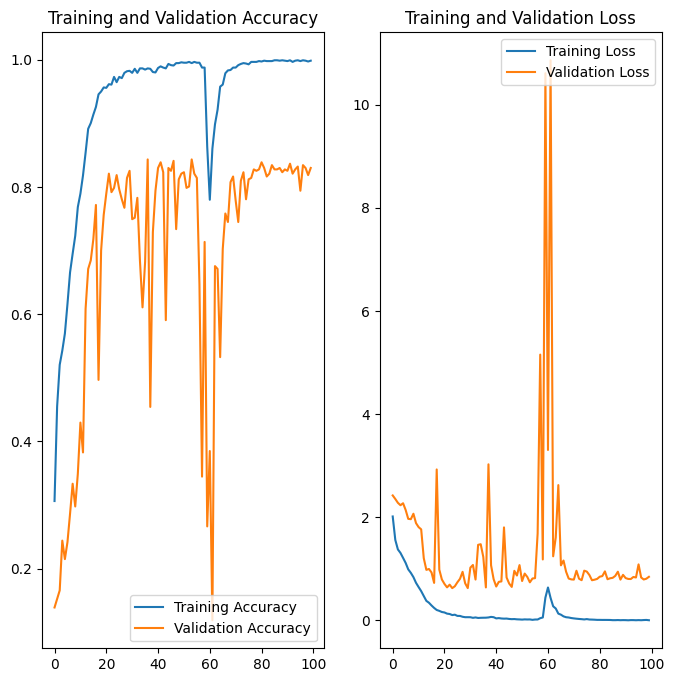

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The model is overfitting.
And there is no improvement as compared to the model with no data augmentation.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
category_distribution = {}
for cat_dir_pathobj in data_dir_train.iterdir():
    cat_name = cat_dir_pathobj.name
    category_distribution[cat_name] = len(list(cat_dir_pathobj.glob("*.jpg")))
    
category_distribution

{'pigmented benign keratosis': 462,
 'melanoma': 438,
 'vascular lesion': 139,
 'actinic keratosis': 114,
 'squamous cell carcinoma': 181,
 'basal cell carcinoma': 376,
 'seborrheic keratosis': 77,
 'dermatofibroma': 95,
 'nevus': 357}

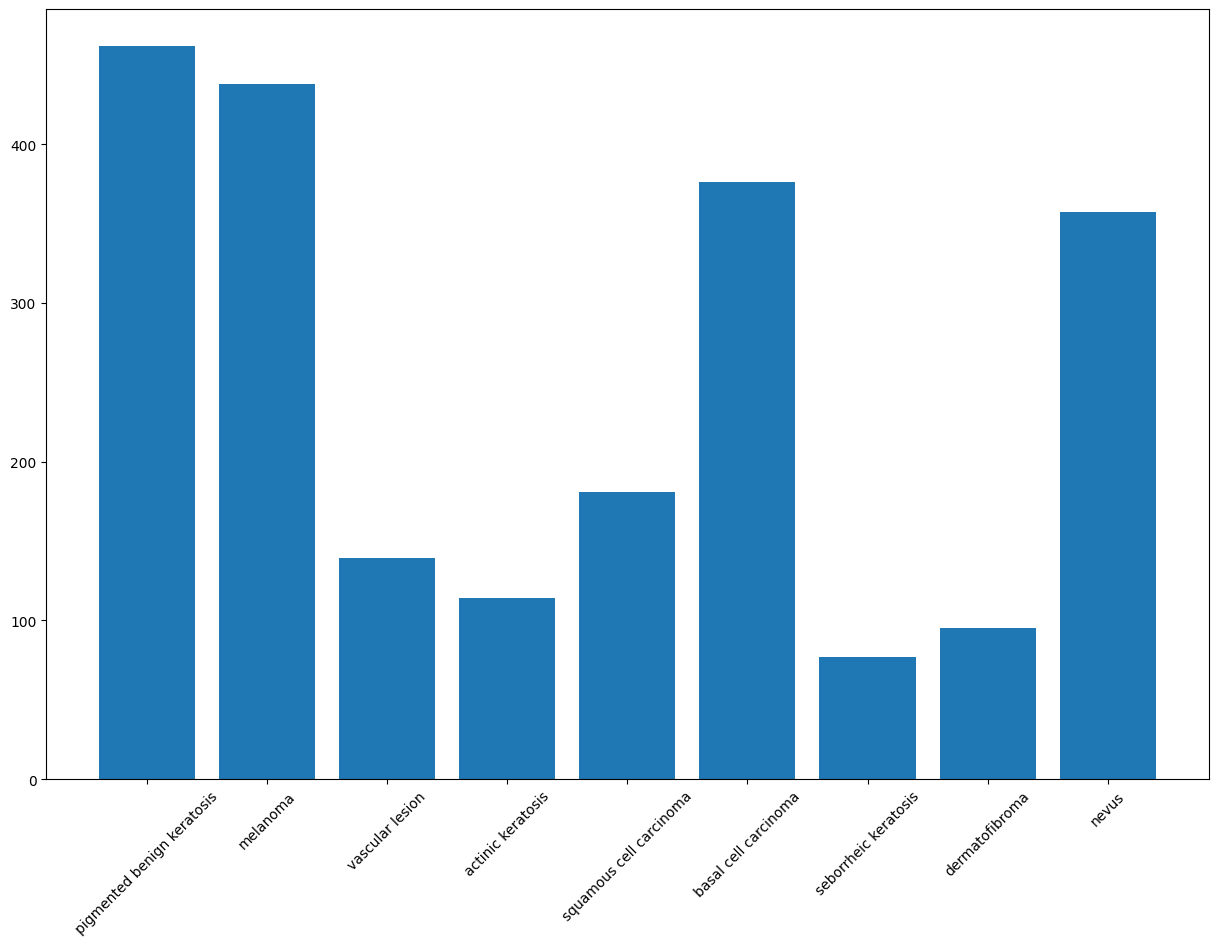

In [24]:
## Your code goes here.
x = []
y = []
for key,val in category_distribution.items():
    x += [key]
    y += [val]
    
plt.figure(figsize=(15,10))
plt.bar(x,y)
plt.xticks(rotation=45)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


As can be seen,
- eborrheic keratosis contains the least number of samples
- pigmented benign keratosis, melanoma, basal cell carcinoma, and nevus contains the most amount of data

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [38]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [44]:
path_to_training_dataset="/kaggle/input/melenoma-data/dataset/Train/"
import Augmentor
for i in class_names:
    if not os.path.exists(path_to_training_dataset + i + "/output"):
        os.makedirs(path_to_training_dataset + i + "/output")
    
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.set_save_format(save_format="PNG")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

OSError: [Errno 30] Read-only file system: '/kaggle/input/melenoma-data/dataset/Train/actinic keratosis/output'

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

After augmented duplicate data, the data distribution

In [23]:
category_distribution = {}
for cat_dir_pathobj in data_dir_train.iterdir():
    cat_name = cat_dir_pathobj.name
    category_distribution[cat_name] = len(list(cat_dir_pathobj.glob("*.jpg")))
    
category_distribution

{'pigmented benign keratosis': 462,
 'melanoma': 438,
 'vascular lesion': 139,
 'actinic keratosis': 114,
 'squamous cell carcinoma': 181,
 'basal cell carcinoma': 376,
 'seborrheic keratosis': 77,
 'dermatofibroma': 95,
 'nevus': 357}

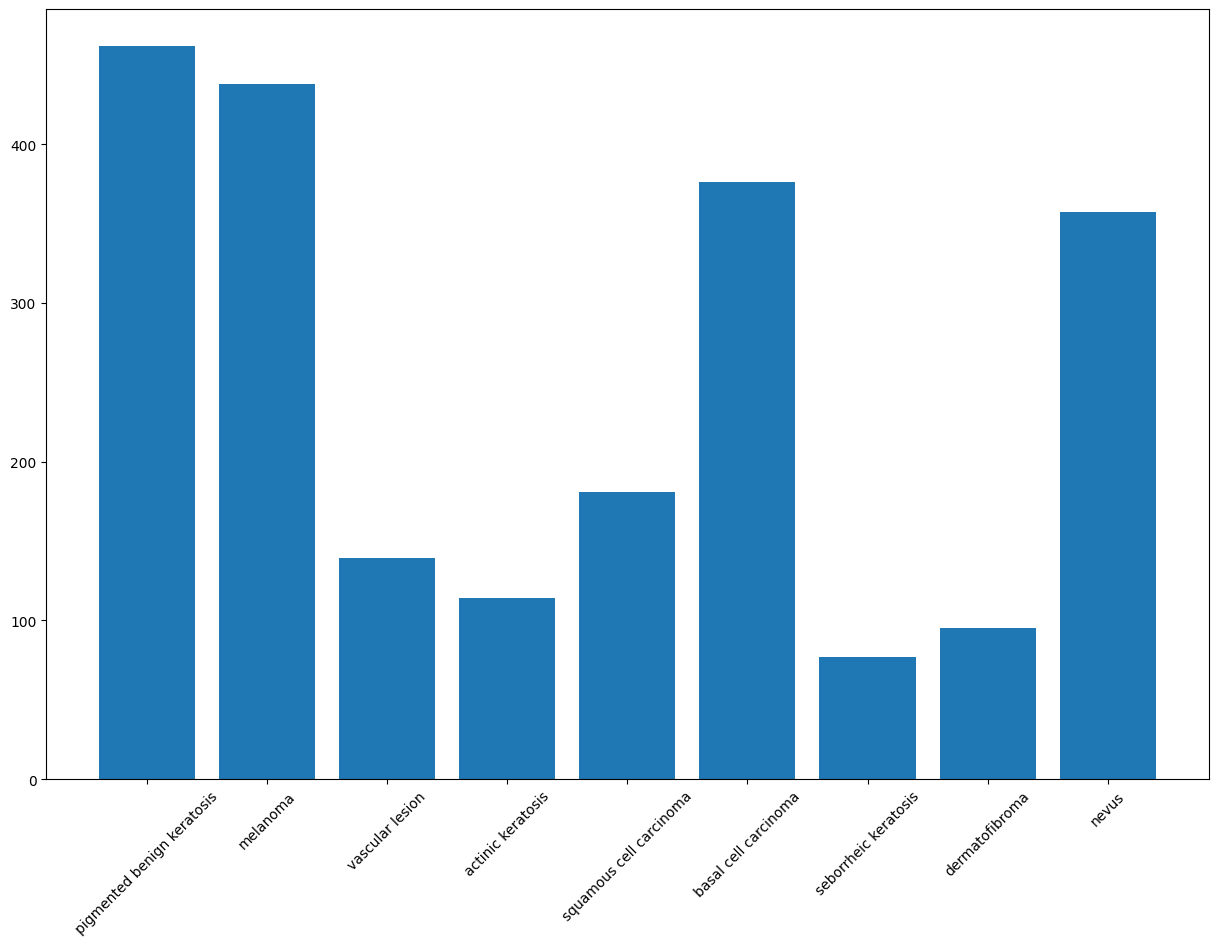

In [24]:
## Your code goes here.
x = []
y = []
for key,val in category_distribution.items():
    x += [key]
    y += [val]
    
plt.figure(figsize=(15,10))
plt.bar(x,y)
plt.xticks(rotation=45)
plt.show()

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = # your model fit code

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

